## Regression method explorer notebook - Paul Giesting

In this notebook I will automate a gridsearch for this regression problem for each of the scikit-learn libraries that I suspect could be suited to handling this problem. Hopefully I can implement a gridsearch for each material quantity to predict, since the PyTorch model seems to make it clear that the quantities regress differently.

First, the model candidates and any appropriate preprocessing:
* Linear regression - wants normal features and targets
  * Could blow things up by introducing polynomial features, self and cross terms
  * Regularization methods: "stepwise", ridge, lasso, elastic net, available as their own methods in scikit-learn
* Support vector regression, `SVR` - costly to run, but good in high dims
* Stochastic gradient descent methods - `loss="epsilon_insensitive"` is an optimized linear SVR
* Nearest neighbors regression - as I recall bad for high dim
* Gaussian Processes - explicitly said to be bad in high dim
* Cross decomposition - very little info in the docs, but good at high feature space and with multicollinearity between the features
* Tree methods - generally want balanced training data, high sample to feature ratio
  * Simple decision tree
  * Random forest
  * Extremely randomized trees
  * XGBoost - separate library from sklearn
* Relevant encapsulation methods
  * `BaggingRegressor(regressor, max_samples, max_features,bootstrap,bootstrap_features,oob_score)`
  * `MultiOutputRegressor` fits one regressor per target, no exploitation of correlations between targets
  * Possibility of using a `RegressorChain`, which apparently *is* capable of exploiting correlations between targets
* Feature selection methods
  * `VarianceThreshold` cuts out low variance features. In this case the early data all look the same, identical decline from 0.5, and this might make a great deal of sense to remove
  * Univariate feature selection - picks best features based on univariate statistics like *F*-score and its associated *p*-value, which are tied to linear relationships, or the alternative mutual information statistic which is nonparametric (not tied to linearity but needs more samples, probably not a problem here)
  * Recursive feature elimination
  * `SelectFromModel` to use constraints on `coef_` or `feature_importances_` outputs to weed out unimportant features
  * `sklearn.pipeline.Pipeline` to preprocess before model training
* Scikit-learn's multilayer perceptron MLP is a basic NN implementation
  * `MLPRegressor` uses no activation function for the output layer and square error for the loss function - supports multioutput regression
  * Uses `alpha` to calibrate L2 regularization strength, try values from 10^-1 down to 10^-6
  * Scaling is important, but nothing is said about distribution
  * `Adam` recommended as the optimizer for large datasets, or else `SGD` with momentum if learning rate is properly tuned

Second, it would be valuable to do some EDA. Let's at least look at the relationships between a few key features (Re and IM at the 180 & echo points) and the four targets.

This is a huge problem at this scale, and I don't want to use all the time till Friday on it; I want to learn some Keras as well. Let's pick a plausible optimal single pipeline.

Well, let's get some EDA up in here in order to get some info to make a decision.

Then the `auto-sklearn` library that scikit-learn's docs link to just looks TOO tasty.

They, or someone, also linked to something called optevolver to massage neural network structure to improve solutions. Also tasty.

## Auto-sklearn

An Automated Machine Learning (AutoML) library that can test and select data and feature preprocessing and model types. The regressor components are listed as scripts in the GitHub repository at auto-sklearn/autosklearn/pipeline/components/regression/:
* adaboost
* ard_regression
* decision_tree
* extra_trees
* gaussian_process
* gradient_boosting
* k_nearest_neighbors
* liblinear_svr
* libsvm_svr
* random_forest
* sgd

In [1]:
import numpy as np

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Load and view the simulated data

Three data-files will be used for the training of the model. Each has 10,000 lines, representing 10,000 simulated $M(t)$ curves for different choices of the four material parameters:

- echos_r.txt  : Real part of the time-dependent magnetization, $\textrm{Re}(M(t))$.
- echos_i.txt  : Imaginary part of the time-dependent magnetization, $\textrm{Im}(M(t))$.
- mat_info.txt : The four material parameters ($\alpha$,$\xi$,$p$,$d$) introduced above.

We also load two smaller files, which give the 500 $M(t)$ curves to be used in submitting your solution to the challenge:

- submit_echos_r.txt
- submit_echos_i.txt

In [2]:
mat_file = "mat_info.txt"
M_file_r = "echos_r.txt" # real part of echos
M_file_i = "echos_i.txt" # imaginary part of echos

In [5]:
print("Downloading files off google drive...")

# data for model creation
r = requests.get("https://docs.google.com/uc?export=download&id=1UZ8wy1Vh4iW1GyaBfWtmjnrKXeDmA2rJ",allow_redirects=True)
open(mat_file, "wb").write(r.content)
r = requests.get("https://docs.google.com/uc?export=download&id=1G82krEg6SVB-PFOS3ei-EH4ZOcseSIEe",allow_redirects=True)
open(M_file_r, "wb").write(r.content)
r = requests.get("https://docs.google.com/uc?export=download&id=1h8MHtV_rQg4TG-YGXqRaDzJU8oRrypCD",allow_redirects=True)
open(M_file_i, "wb").write(r.content)

# data for submission of final model
r = requests.get("https://docs.google.com/uc?export=download&id=14-oz_3OGsTFziJI1FUg0EenMcdQDf2F_",allow_redirects=True)
open("submit_echos_r.txt", "wb").write(r.content)
r = requests.get("https://docs.google.com/uc?export=download&id=1Add2V9cYOBbOCvr1Dj-g4yMlx3LdJY8i",allow_redirects=True)
open("submit_echos_i.txt", "wb").write(r.content)

print("Done with file downloads")

Done with file downloads


In [3]:
print("Loading into numpy arrays...")
# settings of each simulated material:
# format:  |   α  |   ξ  |   p   |   d   |
mat_info = np.loadtxt(mat_file, comments="#", delimiter='\t', unpack=False);

# M(t) curve for each simulation:
M_r = np.loadtxt(M_file_r, comments="#", delimiter='\t', unpack=False);
M_i = np.loadtxt(M_file_i, comments="#", delimiter='\t', unpack=False);
M = M_r + 1j*M_i;
print("Done with numpy loads")

Loading into numpy arrays...
Done with numpy loads


In [6]:
mat_info.shape

(10000, 4)

In [7]:
M_r.shape

(10000, 471)

In [8]:
M_i.shape

(10000, 471)

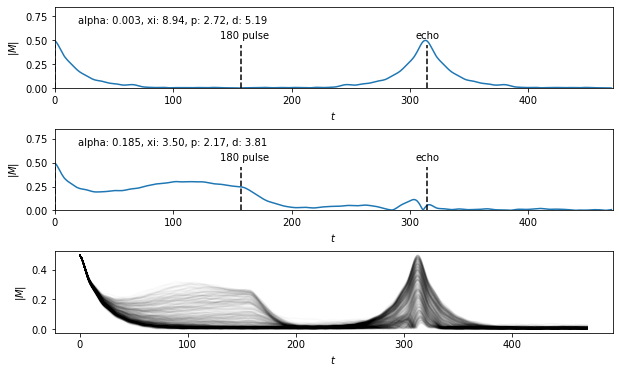

In [5]:
# view the data with three plots, two with a specific curve and one with a lot of curves
fig1, ax1 = plt.subplots(3,1, figsize=(10,6));

# change the following to see different curves
plot_idx1 = 0; # weak spin-spin coupling
plot_idx2 = 10; # strong spin-spin coupling

# string format for material parameter plotting
mat_format = "alpha: %.3f, xi: %.2f, p: %.2f, d: %.2f";

# view the selected curve, with a label of the material data
ax1[0].plot(abs(M[plot_idx1,:]));
ax1[0].text(20,0.68, mat_format % tuple(mat_info[plot_idx1,:]) );
ax1[0].plot([0, 0],[0, .45],'--k')
ax1[0].plot([157, 157],[0, .45],'--k')
ax1[0].text(140,0.52,"180 pulse")
ax1[0].text(305,0.52,"echo")
ax1[0].plot([2*157, 2*157],[0, .45],'--k')
ax1[0].axis([0, 471, 0, 0.85])
ax1[0].set(ylabel="$|M|$", xlabel="$t$");

# view the selected curve, with a label of the material data
ax1[1].plot(abs(M[plot_idx2,:]));
ax1[1].text(20,0.68, mat_format % tuple(mat_info[plot_idx2,:]) );
ax1[1].plot([0, 0],[0, .45],'--k')
ax1[1].plot([157, 157],[0, .45],'--k')
ax1[1].text(140,0.52,"180 pulse")
ax1[1].text(305,0.52,"echo")
ax1[1].plot([2*157, 2*157],[0, .45],'--k')
ax1[1].axis([0, 471, 0, 0.85])
ax1[1].set(ylabel="$|M|$", xlabel="$t$");

ax1[2].plot(abs(M[1:500,:]).T,color=(0,0,0,.025));
ax1[2].set(ylabel="$|M|$", xlabel="$t$");

fig1.subplots_adjust(hspace=.5)

In [11]:
# assemble the Re & Im parts of M at times 157, 314 into a dataframe
# along with the four material properties
var_dict = {'Re(157)':M_r[:,157],
            'Re(314)':M_r[:,314],
            'Im(157)':M_i[:,157],
            'Im(314)':M_i[:,314],
            'alpha':mat_info[:,0],
            'xi':mat_info[:,1],
            'p':mat_info[:,2],
            'd':mat_info[:,3]}
vars = pd.DataFrame(var_dict)
vars.head()

,Re(157),Re(314),Im(157),Im(314),alpha,xi,p,d
0,-0.000069,0.000537,0.002359,-0.495251,0.002960,8.940169,2.717040,5.189847
1,-0.007806,0.001720,-0.004341,-0.234392,0.104608,19.497257,3.971238,4.585938
2,0.011923,-0.000039,0.003908,-0.415851,0.031753,0.939734,3.467178,3.542465
3,-0.011820,0.006070,-0.244514,-0.049414,0.189115,3.864133,3.013146,3.864105
4,-0.022681,-0.000907,-0.089024,-0.218253,0.130628,0.406269,2.520443,3.544876


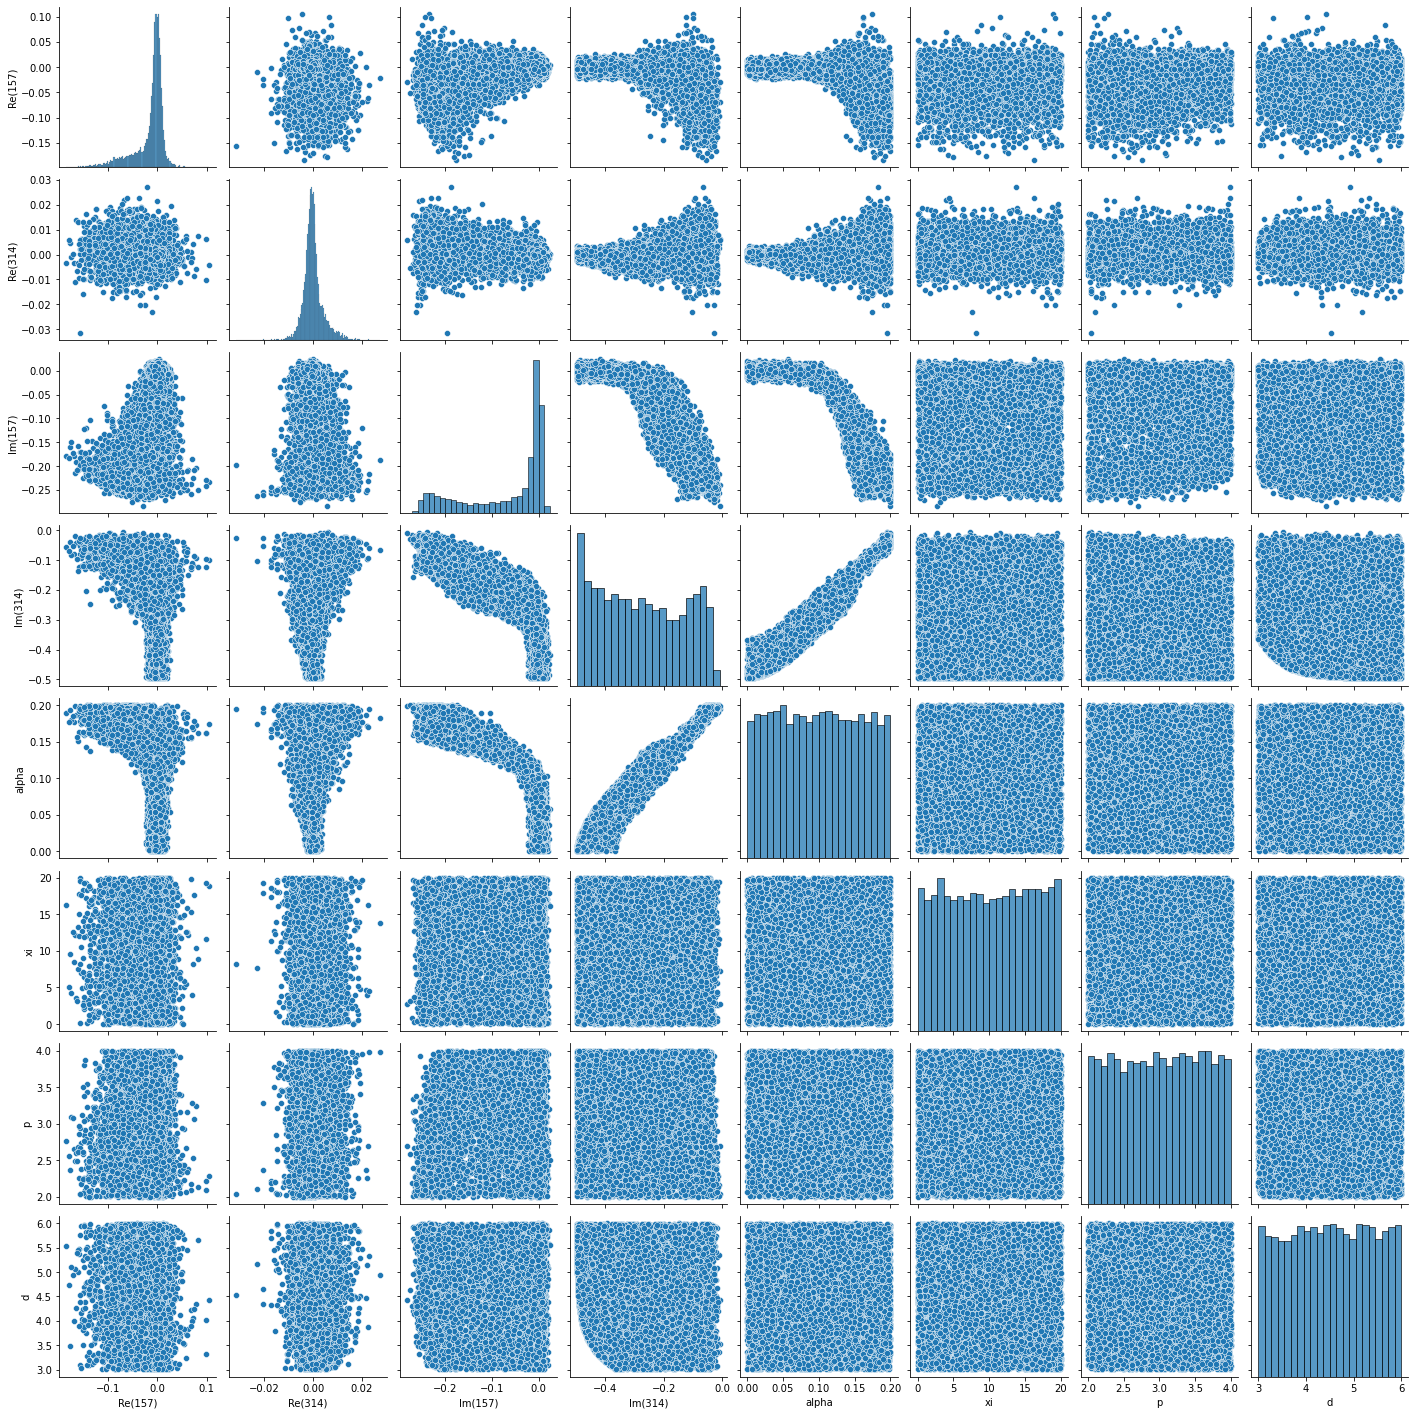

In [12]:
# use seaborn to plot each variable against the others
sns.pairplot(vars)

In [4]:
# partition data into a training and testing set using a random partition

# number of M(t) curves
N_data = np.shape(M)[0]

# pick a 90%/10% split for training/testing
test_frac = 0.10 # fraction of data to save for testing data
div_idx = int(np.floor((1.0-test_frac)*N_data)) # integer number of curves to use for training
order_seed = np.random.permutation(N_data) # random ordering for all curves

train_idx = order_seed[0:div_idx] # first 90% of random order
test_idx = order_seed[div_idx:N_data] # last 10% of random order

# truncate time points to 210, 410
# !!! NOTE: May want to use all of the curve, takes longer to train though !!!
time_keep = range(210,410); # centered roughly at the echo

# concatenate the real and imaginary parts together, to make a real-vector of double the length
M_train = M[train_idx[:,None],time_keep]  # time truncation of input
mat_train = mat_info[train_idx,:]; # get the output
M_train = np.hstack( (np.real(M_train), np.imag(M_train)) ) # real part, then imaginary part

# same as above, but for test
M_test = M[test_idx[:,None],time_keep]
mat_test = mat_info[test_idx,:];
M_test = np.hstack( (np.real(M_test), np.imag(M_test)) )

In [ ]:
# plot the fist 500 elements of the training set, for visualizing variations in the data
plt.plot((M_train[1:500,:]).T,color=(0,0,0,.05));
plt.xlabel("$t$")
plt.ylabel("$M$")
plt.title("Training set with a truncated time axis");

In [11]:
M_train.shape

(9000, 400)

In [5]:
import autosklearn.regression
from autosklearn.metrics import make_scorer

In [3]:
import sklearn.metrics

In [10]:
automl = autosklearn.regression.AutoSklearnRegressor(
    time_left_for_this_task=6000,
    per_run_time_limit=300,
    max_models_on_disc=None,
    ensemble_memory_limit=2*1024,
    ml_memory_limit=4*1024,
    tmp_folder=None,
    output_folder='./autosklearn_out',
    delete_output_folder_after_terminate=False,
    n_jobs=3,
    metric=make_scorer('mean_squared_error',sklearn.metrics.mean_squared_error)
)

In [11]:
automl.fit(M_train, mat_train)

[WARNING] [2020-10-29 01:36:40,229:AutoMLSMBO(1)::ac8630a31a9cfb1a6c328d67a3bff937] Could not find meta-data directory /usr/local/lib/python3.6/dist-packages/autosklearn/metalearning/files/mean_squared_error_multioutput.regression_dense
[WARNING] [2020-10-29 01:42:18,463:smac.runhistory.runhistory2epm.RunHistory2EPM4LogCost] Got cost of smaller/equal to 0. Replace by 0.000010 since we use log cost.
[WARNING] [2020-10-29 01:43:59,443:smac.runhistory.runhistory2epm.RunHistory2EPM4LogCost] Got cost of smaller/equal to 0. Replace by 0.000010 since we use log cost.
[WARNING] [2020-10-29 01:46:56,630:smac.runhistory.runhistory2epm.RunHistory2EPM4LogCost] Got cost of smaller/equal to 0. Replace by 0.000010 since we use log cost.
[WARNING] [2020-10-29 01:47:12,194:smac.runhistory.runhistory2epm.RunHistory2EPM4LogCost] Got cost of smaller/equal to 0. Replace by 0.000010 since we use log cost.
[WARNING] [2020-10-29 01:47:34,651:smac.runhistory.runhistory2epm.RunHistory2EPM4LogCost] Got cost of s

[WARNING] [2020-10-29 02:10:42,408:smac.runhistory.runhistory2epm.RunHistory2EPM4LogCost] Got cost of smaller/equal to 0. Replace by 0.000010 since we use log cost.
[WARNING] [2020-10-29 02:11:17,489:smac.runhistory.runhistory2epm.RunHistory2EPM4LogCost] Got cost of smaller/equal to 0. Replace by 0.000010 since we use log cost.
[WARNING] [2020-10-29 02:11:51,216:smac.runhistory.runhistory2epm.RunHistory2EPM4LogCost] Got cost of smaller/equal to 0. Replace by 0.000010 since we use log cost.
[WARNING] [2020-10-29 02:12:00,865:smac.runhistory.runhistory2epm.RunHistory2EPM4LogCost] Got cost of smaller/equal to 0. Replace by 0.000010 since we use log cost.
[WARNING] [2020-10-29 02:12:17,632:smac.runhistory.runhistory2epm.RunHistory2EPM4LogCost] Got cost of smaller/equal to 0. Replace by 0.000010 since we use log cost.
[WARNING] [2020-10-29 02:12:34,152:smac.runhistory.runhistory2epm.RunHistory2EPM4LogCost] Got cost of smaller/equal to 0. Replace by 0.000010 since we use log cost.
[WARNING] 

[WARNING] [2020-10-29 02:45:46,332:smac.runhistory.runhistory2epm.RunHistory2EPM4LogCost] Got cost of smaller/equal to 0. Replace by 0.000010 since we use log cost.
[WARNING] [2020-10-29 02:45:54,552:smac.runhistory.runhistory2epm.RunHistory2EPM4LogCost] Got cost of smaller/equal to 0. Replace by 0.000010 since we use log cost.
[WARNING] [2020-10-29 02:46:03,127:smac.runhistory.runhistory2epm.RunHistory2EPM4LogCost] Got cost of smaller/equal to 0. Replace by 0.000010 since we use log cost.
[WARNING] [2020-10-29 02:46:30,634:smac.runhistory.runhistory2epm.RunHistory2EPM4LogCost] Got cost of smaller/equal to 0. Replace by 0.000010 since we use log cost.
[WARNING] [2020-10-29 02:46:50,221:smac.runhistory.runhistory2epm.RunHistory2EPM4LogCost] Got cost of smaller/equal to 0. Replace by 0.000010 since we use log cost.
[WARNING] [2020-10-29 02:47:12,491:smac.runhistory.runhistory2epm.RunHistory2EPM4LogCost] Got cost of smaller/equal to 0. Replace by 0.000010 since we use log cost.
[WARNING] 

/usr/local/lib/python3.6/dist-packages/sklearn/base.py:197: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


AutoSklearnRegressor(dask_client=None,
                     delete_output_folder_after_terminate=False,
                     delete_tmp_folder_after_terminate=True,
                     disable_evaluator_output=False, ensemble_memory_limit=2048,
                     ensemble_nbest=50, ensemble_size=50,
                     exclude_estimators=None, exclude_preprocessors=None,
                     get_smac_object_callback=None, include_estimators=None,
                     include_preprocessors=None,
                     initial_configurations_via_metalearning=25,
                     logging_config=None, max_models_on_disc=None,
                     metadata_directory=None, metric=None, ml_memory_limit=4096,
                     n_jobs=3, output_folder='./autosklearn_out',
                     per_run_time_limit=300, resampling_strategy='holdout',
                     resampling_strategy_arguments=None, seed=1,
                     smac_scenario_args=None, time_left_for_this_task=6000,


In [12]:
print(automl.show_models())

[(1.000000, SimpleRegressionPipeline({'data_preprocessing:categorical_transformer:categorical_encoding:__choice__': 'one_hot_encoding', 'data_preprocessing:categorical_transformer:category_coalescence:__choice__': 'minority_coalescer', 'data_preprocessing:numerical_transformer:imputation:strategy': 'median', 'data_preprocessing:numerical_transformer:rescaling:__choice__': 'normalize', 'feature_preprocessor:__choice__': 'random_trees_embedding', 'regressor:__choice__': 'k_nearest_neighbors', 'data_preprocessing:categorical_transformer:category_coalescence:minority_coalescer:minimum_fraction': 0.009456687905885589, 'feature_preprocessor:random_trees_embedding:bootstrap': 'False', 'feature_preprocessor:random_trees_embedding:max_depth': 6, 'feature_preprocessor:random_trees_embedding:max_leaf_nodes': 'None', 'feature_preprocessor:random_trees_embedding:min_samples_leaf': 19, 'feature_preprocessor:random_trees_embedding:min_samples_split': 13, 'feature_preprocessor:random_trees_embedding:m

In [13]:
predictions = automl.predict(M_test)

In [4]:
import pickle

In [15]:
with open('autosklearn-results.pkl','wb') as cellar:
    pickle.dump([predictions,mat_test],cellar)

In [5]:
with open('autosklearn-results.pkl','rb') as cellar:
    [predictions,mat_test] = pickle.load(cellar)

The quality of the model will be judged by the minimization of the error function:


$\textrm{Err} = \sum_{v=1}^{4} \sum_{i=i}^{500} \left( \frac{v^i_\textrm{model} - v^i_\textrm{true}}{w(v)} \right)^2 $

where $v^i$ is one of the four spin-interaction variables for echo number $i$, and $w_v$ normalizes the variation in each variable, according to:

$w(\alpha) = 0.2$

$w(\xi) = 20$

$w(p) = 2$

$w(d) = 3.$

In [15]:
# check results on test set
def weight_mse(truth,predict):
    erf = 0.0
    weight = [0.2, 20, 2, 3]
    for col in range(4):
        erf += sklearn.metrics.mean_squared_error(truth[:,col],predict[:,col]) / (weight[col]**2)
    return erf

In [16]:
type(mat_test)

numpy.ndarray

In [17]:
type(predictions)

numpy.ndarray

In [18]:
print("Competition score:", weight_mse(mat_test, predictions))

Competition score: 0.4856677046369669


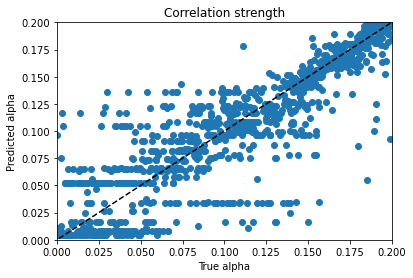

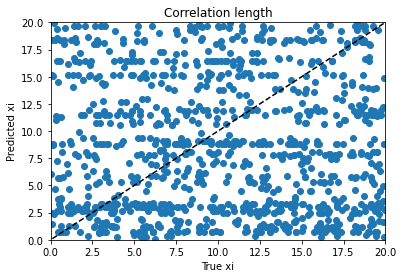

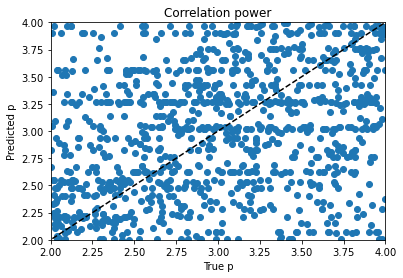

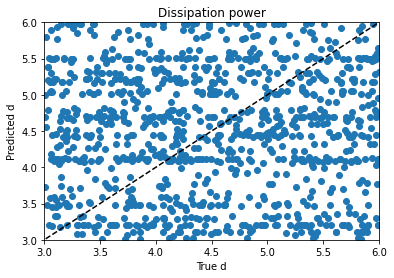

In [8]:
plt.scatter(mat_test[:,0],predictions[:,0]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True alpha");
plt.ylabel("Predicted alpha");
plt.axis([0, .2, 0, .2])
plt.title("Correlation strength")

plt.figure()
plt.scatter(mat_test[:,1],predictions[:,1]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True xi");
plt.ylabel("Predicted xi");
plt.axis([0, 20, 0, 20])
plt.title("Correlation length")

plt.figure()
plt.scatter(mat_test[:,2],predictions[:,2]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True p");
plt.ylabel("Predicted p");
plt.axis([2, 4, 2, 4])
plt.title("Correlation power")

plt.figure()
plt.scatter(mat_test[:,3],predictions[:,3]);
plt.plot([-100, 100],[-100, 100],"--k")
plt.xlabel("True d");
plt.ylabel("Predicted d");
plt.axis([3, 6, 3, 6]);
plt.title("Dissipation power");

## Submission format

When we downloaded the data for the model development, we also downloaded 500 spin echos into "submit_echos_r.txt" and "submit_echos_i.txt".
These share the same format as the "echos.txt" used for the model training above.

Use your model to predict the four spin-interaction variables from the 500 echos, and submit your results in a tab delimited .txt file of dimensions 500 x 4 matching the "mat_info.txt" format.

That is, the columns should be:

| $\alpha$ | $\xi$ | $p$ | $d$ |
      
and there should be 500 rows.

Name this file "submitted_mat_info.txt"

Your submission should include your notebook as well as the predicted value file "submitted_mat_info.txt"



## Contributors

- Stephen Carr (Brown Theoretical Physics Center)
- Charles Snider (Brown University)
- J. B. Marston (Brown Theoretical Physics Center)
- V. F. Mitrović (Brown University)
- D. E. Feldman (Brown Theoretical Physics Center)
- C. Ramanathan (Dartmouth College)
